# Character-Level LSTM in PyTorch -- Generate names and classify real/fake names


In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from functools import reduce
import random
import string

# Task 1

## T1 - Load in Data

Here I created a small dataset (#=6000 names) based on Top 6000 popularity ranks. The txt file is shared to this link also: https://drive.google.com/file/d/1b-0QQGd9nxcI3MvtJYzpBKn67ZxsAG98/view?usp=sharing.

In [2]:
# open text file and read in data as `text`
with open('yob2018-small.txt', 'r') as f:
    text = f.read()

### T1 - Tokenization

In the second cell, below, I'm creating a couple **dictionaries** to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [3]:
# encode the text and map each character to an integer and vice versa

# we create two dictonaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers

chars = tuple(set(text))

int2char = dict(enumerate(chars))

char2int = {ch: ii for ii, ch in int2char.items()}

encoded = np.array([char2int[ch] for ch in text])

## T1 - Pre-processing the data

The LSTM expects an input that is **one-hot encoded** meaning that each character is converted into an integer (via our created dictionary) and *then* converted into a column vector where only it's corresponsing integer index will have the value of 1 and the rest of the vector will be filled with 0's. Below is the one-hot encoding the data function.


In [4]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

## T1 - Making training batches


To train on this data, below is to create mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

In [5]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        
        # The features
        x = arr[:, n:n+n_steps]
        
        # The targets, shifted by one
        y = np.zeros_like(x)
        
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y
    #return x, y

### T1 - Test the Implementation

Now I'll make some data sets and we can check out what's going on as we batch data. Here, as an example, I'm going to use a batch size of 10 and 50 sequence steps.

In [6]:
batches = get_batches(encoded, 10, 50)
#print(len(encoded))
x, y = next(batches)

In [7]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[25 52 52 47 31 44 37  9 23  9]
 [32 31 35  9 52 26 32 41 31 25]
 [37 24  4  4 31 35 24  4 39 37]
 [47 24 37 32 32 31 34 47 52 47]
 [22 47  4  4 31 35 24 41 47 28]
 [29  4  4  9 32 31 48 24 32  2]
 [32 24 31 43 37 47 29 41 47 31]
 [32 24 47 28 31 33 47 19 19 24]
 [31 20 47 41  9  4 47 31 25 52]
 [31 35 32 47  4 47 31 35 32 41]]

y
 [[52 52 47 31 44 37  9 23  9 47]
 [31 35  9 52 26 32 41 31 25 52]
 [24  4  4 31 35 24  4 39 37 32]
 [24 37 32 32 31 34 47 52 47 41]
 [47  4  4 31 35 24 41 47 28 31]
 [ 4  4  9 32 31 48 24 32  2 47]
 [24 31 43 37 47 29 41 47 31 43]
 [24 47 28 31 33 47 19 19 24 31]
 [20 47 41  9  4 47 31 25 52 32]
 [35 32 47  4 47 31 35 32 41  9]]


## T1 - Defining the LSTM model_1 with PyTorch

### Model Structure

In `__init__` the suggested structure is as follows:
* Create and store the necessary dictionaries (this has been done for you)
* Define an LSTM layer that takes as params: an input size (the number of characters), a hidden layer size `n_hidden`, a number of layers `n_layers`, a dropout probability `drop_prob`, and a batch_first boolean (True, since we are batching)
* Define a dropout layer with `dropout_prob`
* Define a fully-connected layer with params: input size `n_hidden` and output size (the number of characters)
* Finally, initialize the weights (again, this has been given)

Note that some parameters have been named and given in the `__init__` function, and we use them and store them by doing something like `self.drop_prob = drop_prob`.

In [8]:
class Gene_LSTM(nn.Module):
    
    def __init__(self, tokens, n_steps=100, n_hidden=128, n_layers=1,
                       drop_prob=0.5, lr=0.0001):   #  
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # Creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## Define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
             dropout=drop_prob, batch_first=True)   # 
        
        ## Define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## Define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        # Initialize the weights
        self.init_weights()
      
    
    def forward(self, x, hc):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        
        ## Get x, and the new hidden state (h, c) from the lstm
        x, (h, c) = self.lstm(x, hc)
        
        ## Ppass x through the dropout layer
        x = self.dropout(x)
        
        # Stack up LSTM outputs using view
        #x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        x = x.reshape(x.size()[0]*x.size()[1], self.n_hidden)
        
        ## Put x through the fully-connected layer
        x = self.fc(x)
        
        # Return x and the hidden state (h, c)
        return x, (h, c)
    
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character, predict the next character.
        
            Returns the predicted character and the hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        x = np.array([[self.char2int[char]]])
        x = one_hot_encode(x, len(self.chars))
        
        inputs = torch.from_numpy(x)
        
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([each.data for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())
        

In [10]:
loss_val_list = []
loss_list = []
def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: Gene_LSTM network
        data: name data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every: Number of steps for printing training and validation loss
    
    '''
    
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    
    for e in range(epochs):
        
        h = net.init_hidden(n_seqs)
        
        for x, y in get_batches(data, n_seqs, n_steps):
            
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)
     
            loss = criterion(output, targets.view(n_seqs*n_steps).type(torch.LongTensor))

            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            opt.step()
            
            if counter % print_every == 0:
                
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
         
                for x, y in get_batches(val_data, n_seqs, n_steps):
            
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.view(n_seqs*n_steps).type(torch.LongTensor))
                    #print(val_loss)
                    val_losses.append(val_loss.item())
                    
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                loss_val_list.append(np.mean(val_losses))
                loss_list.append(loss.item())
                

## T1 - Train the model

In [11]:
if 'net' in locals():
    del net
    
# Initialize and print the network
net1 = Gene_LSTM(chars, n_hidden=128, n_layers=1)

print(net1)

Gene_LSTM(
  (lstm): LSTM(53, 128, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=53, bias=True)
)


//anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [12]:
n_seqs, n_steps = 10, 300

train(net1, encoded, epochs=100, n_seqs=n_seqs, n_steps=n_steps, lr=0.0001, cuda=False, print_every=10)

Epoch: 1/100... Step: 10... Loss: 4.0479... Val Loss: 4.0414
Epoch: 2/100... Step: 20... Loss: 3.9993... Val Loss: 3.9708
Epoch: 3/100... Step: 30... Loss: 3.9406... Val Loss: 3.9157
Epoch: 4/100... Step: 40... Loss: 3.8751... Val Loss: 3.8633
Epoch: 5/100... Step: 50... Loss: 3.8363... Val Loss: 3.8155
Epoch: 5/100... Step: 60... Loss: 3.7598... Val Loss: 3.7566
Epoch: 6/100... Step: 70... Loss: 3.6897... Val Loss: 3.6894
Epoch: 7/100... Step: 80... Loss: 3.6286... Val Loss: 3.6105
Epoch: 8/100... Step: 90... Loss: 3.5344... Val Loss: 3.5320
Epoch: 9/100... Step: 100... Loss: 3.4494... Val Loss: 3.4408
Epoch: 10/100... Step: 110... Loss: 3.4054... Val Loss: 3.3814
Epoch: 10/100... Step: 120... Loss: 3.3463... Val Loss: 3.3436
Epoch: 11/100... Step: 130... Loss: 3.3308... Val Loss: 3.3254
Epoch: 12/100... Step: 140... Loss: 3.2880... Val Loss: 3.2979
Epoch: 13/100... Step: 150... Loss: 3.2652... Val Loss: 3.2729
Epoch: 14/100... Step: 160... Loss: 3.2581... Val Loss: 3.2695
Epoch: 15/1

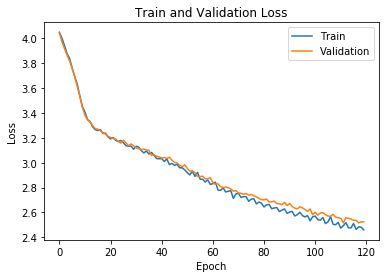

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(loss_list,label='Train')
plt.plot(loss_val_list,label='Validation')

plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


## T1 - Save the model 
After training, save the model so we can load it again later if we need too. Here I'm saving the parameters needed to create the same architecture, the hidden layer hyperparameters.

In [15]:
# change the name, for saving multiple files
model_name = 'LSTM_T1.net'

checkpoint = {'n_hidden': net1.n_hidden,
              'n_layers': net1.n_layers,
              'state_dict': net1.state_dict(),
              'tokens': net1.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

## T1 - Sampling

Now that the model is trained, we'll want to sample from it. To sample, we pass in a character and have the network predict the next character. Then we take that character, pass it back in, and get another predicted character. Given the **input (size)** in the function **generate_name**, you can generate a given sized name.

In [16]:
def generate_name(net, size, prime, top_k=None, cuda=False):
        
    if cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    
    h = net.init_hidden(1)
    
    for ch in prime:
        char, h = net.predict(ch, h, cuda=cuda, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        #print(ii)
        char, h = net.predict(chars[-1], h, cuda=cuda, top_k=top_k)
        chars.append(char)
        #print(chars)

    return ''.join(chars)

In [18]:
print(generate_name(net1, 4, prime='A', top_k=5, cuda=False))

Alile



## T1 - Load_model_T1

In [19]:
# Here we have loaded in a model that trained and shared on drive, 'LSTM_T1.net'

#https://drive.google.com/file/d/105D2knhyMdowATI8IVCndfNrHvrBCJYk/view?usp=sharing
fid = '105D2knhyMdowATI8IVCndfNrHvrBCJYk'

import wget
def download(fid, fn):
    durl = 'https://drive.google.com/' + 'uc?export=download&id=' + fid
    print('downloading from', durl)
    wget.download(durl, fn)

def load_model_T1():
    download(fid, 'LSTM_T1.net')
    with open('LSTM_T1.net', 'rb') as f:
         checkpoint = torch.load(f)
    Loaded_model = Gene_LSTM(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    Loaded_model.load_state_dict(checkpoint['state_dict'])
    
    return Loaded_model

In [20]:
# Change cuda to True if you are using GPU!
loaded = load_model_T1()
print(generate_name(loaded, 10, cuda=False, top_k=5, prime="A"))

downloading from https://drive.google.com/uc?export=download&id=105D2knhyMdowATI8IVCndfNrHvrBCJYk
Arrin
Allane


//anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Task 2

## T2 - Generate fake names

In [23]:
def generate_fake_name(length):
    name_letters = 'abcdefghijklmnopqrstuvwxyz'
    name_len = length-1 #random.randint(0,26)
    name_letter = random.sample(name_letters,name_len)
    name_letter.insert(0,name_letter[0].upper())
    fake_name = reduce(lambda x,y:x+y,name_letter)
    return str(fake_name)+'\n'
fake_names=''
real_names=''

with open('yob2018-small.txt', 'r') as fp:
    real_names=fp.read()
    
with open('yob2018-small.txt', 'r') as fp:   
    line = fp.readline()
    cnt = 1
    while line:
        #print("Line {}: {}".format(cnt, line.strip()))
        fake_names+=generate_fake_name(len(line.strip()))
        line = fp.readline()
        cnt += 1            

category_lines = {'Real':real_names,'Fake':fake_names}
all_categories = ['Real','Fake']

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_categories = len(all_categories)


In [24]:
def indices_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    for i in range(one_hot.shape[0]):
        one_hot[i]=arr.flatten()[i]
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    #print(one_hot.shape)
    return one_hot

In [25]:
# encode the text and map each character to an integer and vice versa

# we create two dictonaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers

chars = tuple(set(real_names))

int2char = dict(enumerate(chars))

char2int = {ch: ii for ii, ch in int2char.items()}

encoded1 = np.array([ord(ch)-ord('A') for ch in real_names])
encoded2=np.array([ord(ch)-ord('A') for ch in fake_names])
encoded=np.append(encoded1, encoded2)
target1= np.array([1 for ch in real_names])
target2=np.array([0 for ch in fake_names])
target=np.append(target1, target2)


In [28]:
def get_batches(arr,label,n_seqs, n_steps):
    ''''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    label = label[:n_batches * batch_size]
    
    # Reshape into n_seqs rows
    label = label.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        
        # The features
        x = arr[:, n:n+n_steps]
        
        # The targets, shifted by one
        #y = np.zeros_like(x)
        y = label[:, n:n+n_steps]
        
        yield x,y
        
    #return x, y

## T2 - The is_real_name function is defined in Classifier_LSTM

In [29]:
class Classifier_LSTM(nn.Module):
    
    def __init__(self, tokens, n_steps=100, n_hidden=128, n_layers=1,
                       drop_prob=0.5, lr=0.0001):   #  
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # Creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## Define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
             dropout=drop_prob, batch_first=True)   # 
        
        ## Define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## Define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        self.sig = nn.Sigmoid()
        self.h=self.init_hidden(1)
        # Initialize the weights
        self.init_weights()
      
    
    def forward(self, x, hc):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        
        ## Get x, and the new hidden state (h, c) from the lstm
        x, (h, c) = self.lstm(x, hc)
        
        ## Ppass x through the dropout layer
        x = self.dropout(x)
        
        # Stack up LSTM outputs using view
        #x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        x = x.reshape(x.size()[0]*x.size()[1], self.n_hidden)

        x=self.sig(x)

        # Return x and the hidden state (h, c)
        return x, (h, c)
    
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())
    
    def is_real_name(self, name):
        h = self.init_hidden(1)      
        p = 0   
        for char in name:
            x = np.array([[ord(char)-ord('A')]])
            x = indices_encode(x, len(self.chars))
            inputs = torch.from_numpy(x)           
            h = tuple([each.data for each in h])
            out, h = self.forward(inputs,h)
            p = torch.sigmoid(out).data
                
       # print("SIGMOID value is "+str(torch.mean(p, dim=1)))
        p = torch.mean(p, dim=1)
        if p>0.5:
            print("This is a real name")
        else:
            print("This is a fake name")
        

In [30]:
loss_val_list = []
loss_list = []
def train(net, data, label, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: Gene_LSTM network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every: Number of steps for printing training and validation loss
    
    '''
    
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    label,val_label=label[:val_idx], label[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    
    for e in range(epochs):
        
        h = net.init_hidden(n_seqs)
        
        for x, y in get_batches(data, label, n_seqs, n_steps):
            
            counter += 1
            x = indices_encode(x,n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)
            
            net.h=h
            loss = criterion(output, targets.reshape(n_seqs*n_steps).type(torch.LongTensor))
            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            opt.step()
            
            if counter % print_every == 0:
                
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
    
                for x, y in get_batches(val_data,val_label, n_seqs, n_steps):
                    x = indices_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.reshape(n_seqs*n_steps).type(torch.LongTensor))
                    val_losses.append(val_loss.item())
                    
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                loss_val_list.append(np.mean(val_losses))
                loss_list.append(loss.item())
                

In [31]:
if 'net' in locals():
    del net

In [32]:
# Initialize and print the network
#net2 = Classifier_LSTM(vocab_size=len(real_names), output_size= len(real_names),n_embedding=320, n_hidden=128, n_layers=1)
net2 = Classifier_LSTM(chars, n_hidden=128, n_layers=1)
print(net2)

Classifier_LSTM(
  (lstm): LSTM(53, 128, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=53, bias=True)
  (sig): Sigmoid()
)


In [33]:
n_seqs, n_steps = 10, 300
#print(encoded.shape)
train(net2, encoded,target,epochs=100, n_seqs=n_seqs, n_steps=n_steps, lr=0.0001, cuda=False, print_every=10)
#train(net2, real_names, epochs=50, n_seqs=n_seqs, n_steps=n_steps, lr=0.0001, cuda=False, print_every=10)

Epoch: 1/100... Step: 10... Loss: 4.6998... Val Loss: 4.6982
Epoch: 1/100... Step: 20... Loss: 4.6858... Val Loss: 4.6831
Epoch: 2/100... Step: 30... Loss: 4.6682... Val Loss: 4.6687
Epoch: 2/100... Step: 40... Loss: 4.6604... Val Loss: 4.6607
Epoch: 2/100... Step: 50... Loss: 4.6510... Val Loss: 4.6450
Epoch: 3/100... Step: 60... Loss: 4.6199... Val Loss: 4.6178
Epoch: 3/100... Step: 70... Loss: 4.6060... Val Loss: 4.6078
Epoch: 4/100... Step: 80... Loss: 4.6054... Val Loss: 4.6070
Epoch: 4/100... Step: 90... Loss: 4.5952... Val Loss: 4.5911
Epoch: 4/100... Step: 100... Loss: 4.5914... Val Loss: 4.5883
Epoch: 5/100... Step: 110... Loss: 4.5863... Val Loss: 4.5879
Epoch: 5/100... Step: 120... Loss: 4.5911... Val Loss: 4.5802
Epoch: 6/100... Step: 130... Loss: 4.5795... Val Loss: 4.5732
Epoch: 6/100... Step: 140... Loss: 4.5737... Val Loss: 4.5751
Epoch: 6/100... Step: 150... Loss: 4.5716... Val Loss: 4.5703
Epoch: 7/100... Step: 160... Loss: 4.5719... Val Loss: 4.5684
Epoch: 7/100... S

Epoch: 53/100... Step: 1320... Loss: 4.5473... Val Loss: 4.5482
Epoch: 54/100... Step: 1330... Loss: 4.5435... Val Loss: 4.5474
Epoch: 54/100... Step: 1340... Loss: 4.5461... Val Loss: 4.5532
Epoch: 54/100... Step: 1350... Loss: 4.5485... Val Loss: 4.5491
Epoch: 55/100... Step: 1360... Loss: 4.5528... Val Loss: 4.5494
Epoch: 55/100... Step: 1370... Loss: 4.5498... Val Loss: 4.5472
Epoch: 56/100... Step: 1380... Loss: 4.5437... Val Loss: 4.5485
Epoch: 56/100... Step: 1390... Loss: 4.5495... Val Loss: 4.5509
Epoch: 56/100... Step: 1400... Loss: 4.5502... Val Loss: 4.5460
Epoch: 57/100... Step: 1410... Loss: 4.5469... Val Loss: 4.5486
Epoch: 57/100... Step: 1420... Loss: 4.5455... Val Loss: 4.5483
Epoch: 58/100... Step: 1430... Loss: 4.5469... Val Loss: 4.5470
Epoch: 58/100... Step: 1440... Loss: 4.5492... Val Loss: 4.5501
Epoch: 58/100... Step: 1450... Loss: 4.5495... Val Loss: 4.5468
Epoch: 59/100... Step: 1460... Loss: 4.5501... Val Loss: 4.5482
Epoch: 59/100... Step: 1470... Loss: 4.5

In [34]:
# change the name, for saving multiple files
model_name2 = 'LSTM_T2.net'

checkpoint = {'n_hidden': net1.n_hidden,
              'n_layers': net1.n_layers,
              'state_dict': net2.state_dict(),
              'tokens': net2.chars}

with open(model_name2, 'wb') as f:
    torch.save(checkpoint, f)

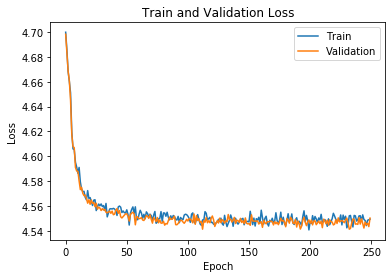

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(loss_list,label='Train')
plt.plot(loss_val_list,label='Validation')

plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [36]:
# Here we have loaded in a model that trained over 1 epoch `rnn_1_epoch.net`

#https://drive.google.com/file/d/16233aakjLOGu5_r-KwynsP-bC73n2aCy/view?usp=sharing
fid2 = '16233aakjLOGu5_r-KwynsP-bC73n2aCy'

import wget
def download2(fid2, fn):
    durl = 'https://drive.google.com/' + 'uc?export=download&id=' + fid2
    print('downloading from', durl)
    wget.download2(durl, fn)

def load_model_T2():
    download(fid2, 'LSTM_T2.net')
    with open('LSTM_T2.net', 'rb') as f:
         checkpoint = torch.load(f)
    Loaded_model = Classifier_LSTM(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    Loaded_model.load_state_dict(checkpoint['state_dict'])
    
    return Loaded_model

In [37]:
# Change cuda to True if you are using GPU!
loaded = load_model_T2()
print(net2.is_real_name("Allen"))

downloading from https://drive.google.com/uc?export=download&id=16233aakjLOGu5_r-KwynsP-bC73n2aCy
This is a real name
None
